In [ ]:
!git clone https://github.com/foxyhyun/NPL_Workshop_2026.git
%cd NPL_Workshop_2026

Cloning into 'NPL_Workshop_2026'...
remote: Enumerating objects: 1206, done.
remote: Total 1206 (delta 0), reused 0 (delta 0), pack-reused 1206 (from 1)
Receiving objects: 100% (1206/1206), 179.15 MiB | 19.31 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/NPL_Workshop_2026


# Data Load

GT_DIR  : /content/NPL_Workshop_2026/data/GT
NOISY_DIR: /content/NPL_Workshop_2026/data/Noisy

Counts:
 GT  : 300
 NOISY 300


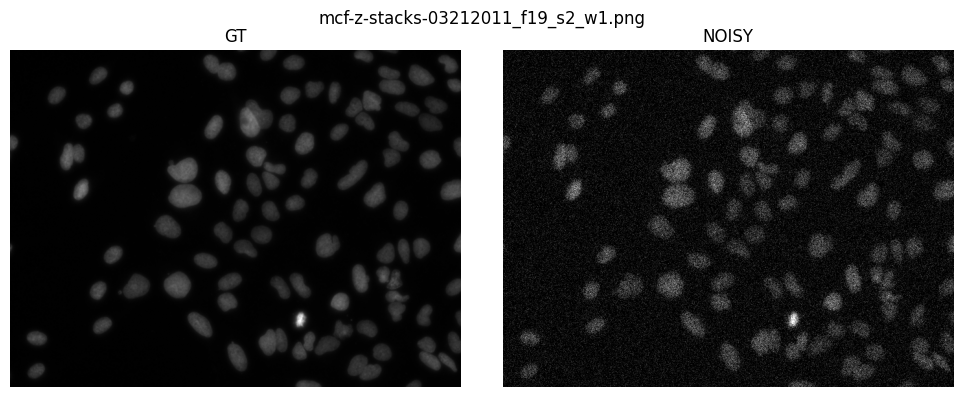

Chosen file: mcf-z-stacks-03212011_f19_s2_w1.png
GT  : /content/NPL_Workshop_2026/data/GT/mcf-z-stacks-03212011_f19_s2_w1.png
NOISY: /content/NPL_Workshop_2026/data/Noisy/mcf-z-stacks-03212011_f19_s2_w1.png


In [ ]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

DATA_ROOT = Path("/content/NPL_Workshop_2026/data")
GT_DIR = DATA_ROOT / "GT"
NOISY_ROOT = DATA_ROOT / "Noisy"

assert GT_DIR.exists(), f"GT folder not found: {GT_DIR}"
assert NOISY_ROOT.exists(), f"Noisy folder not found: {NOISY_ROOT}"

mask_subdirs = [d for d in MASK_ROOT.iterdir() if d.is_dir()]
if mask_subdirs:
    NOISY_DIR = max(mask_subdirs, key=lambda d: len(list(d.glob("*.png"))))
else:
    NOISY_DIR = NOISY_ROOT

print("GT_DIR  :", GT_DIR)
print("NOISY_DIR:", NOISY_DIR)

gt_files = sorted(GT_DIR.glob("*.png"))
noisy_files = sorted(NOISY_DIR.glob("*.png"))

print("\nCounts:")
print(" GT  :", len(gt_files))
print(" NOISY", len(noisy_files))

gt_names = set(p.name for p in gt_files)
noisy_names = set(p.name for p in noisy_files)

common = sorted(list(gt_names & noisy_names))
assert len(common) > 0, "No common filenames between GT and Mask."

name = random.choice(common)
gt_path = GT_DIR / name
noisy_path = NOISY_DIR / name

gt = cv2.imread(str(gt_path), cv2.IMREAD_UNCHANGED)
noisy = cv2.imread(str(noisy_path), cv2.IMREAD_UNCHANGED)

def to_u8(x):
    x = x.astype(np.float32)
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    return (x * 255).astype(np.uint8)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("GT");   plt.imshow(to_u8(gt), cmap="gray"); plt.axis("off")
plt.subplot(1,2,2); plt.title("NOISY"); plt.imshow(to_u8(noisy), cmap="gray"); plt.axis("off")
plt.suptitle(name)
plt.tight_layout()
plt.show()

print("Chosen file:", name)
print("GT  :", gt_path)
print("NOISY:", noisy_path)


# Classic Denoising Method - Mean/Median/Gaussian Filtering

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# === Kernel Size ===
# You can choose and see different results
K_MEAN = 5        # [ 3, 5. 7]
K_MED  = 5        # [3, 5, 7]
K_GAUS = 5        # [3, 5, 7]
SIGMA  = 1.0      # for Gasussian Filtering
# ==============================

gt = cv2.imread(str(gt_path), cv2.IMREAD_UNCHANGED)
noisy = cv2.imread(str(noisy_path), cv2.IMREAD_UNCHANGED)

# Filters
# Mean Filtering
mean_out   = cv2.blur(noisy, (K_MEAN, K_MEAN))
# Median Filtering
median_out = cv2.medianBlur(noisy, K_MED)
# Gaussian Filtering
gauss_out  = cv2.GaussianBlur(noisy, (K_GAUS, K_GAUS), SIGMA)


PSNR Noisy : 21.56 dB
PSNR Mean  : 28.87 dB   (k=5)
PSNR Median: 32.60 dB (k=5)
PSNR Gauss : 28.19 dB  (k=5, sigma=1.0)


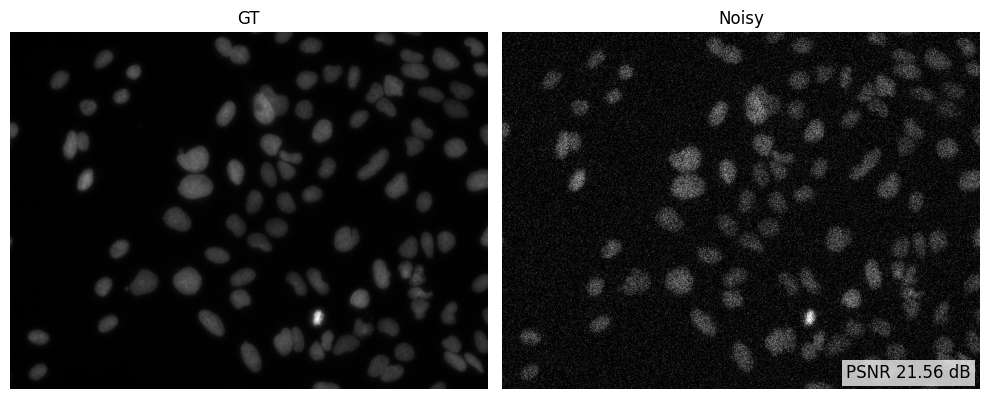

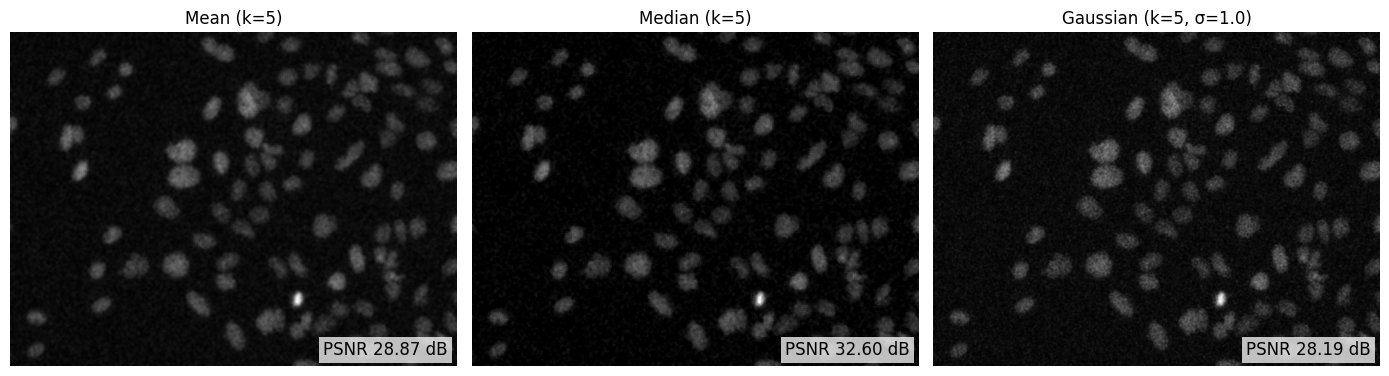

In [ ]:
# === You should implement ===
def psnr(a, b):
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    MAX = 255.0
    mse = ?? # hint : search in google "np.mean"
    output = ?? # hint : search in google "np.log10"
    return output

ps_noisy  = psnr(noisy, gt)
ps_mean   = psnr(mean_out, gt)
ps_median = psnr(median_out, gt)
ps_gauss  = psnr(gauss_out, gt)

print(f"PSNR Noisy : {ps_noisy:.2f} dB")
print(f"PSNR Mean  : {ps_mean:.2f} dB   (k={K_MEAN})")
print(f"PSNR Median: {ps_median:.2f} dB (k={K_MED})")
print(f"PSNR Gauss : {ps_gauss:.2f} dB  (k={K_GAUS}, sigma={SIGMA})")

def put_psnr(ax, psnr_val, fontsize=12):
    ax.text(
        0.98, 0.02, f"PSNR {psnr_val:.2f} dB",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=fontsize,
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", pad=3)
    )

plt.figure(figsize=(10,4))

ax = plt.subplot(1,2,1)
ax.set_title("GT")
ax.imshow(gt, cmap="gray")
ax.axis("off")

ax = plt.subplot(1,2,2)
ax.set_title("Noisy")
ax.imshow(noisy, cmap="gray")
ax.axis("off")
put_psnr(ax, ps_noisy)

plt.tight_layout()
plt.show()


plt.figure(figsize=(14,4))

ax = plt.subplot(1,3,1)
ax.set_title(f"Mean (k={K_MEAN})")
ax.imshow(mean_out, cmap="gray")
ax.axis("off")
put_psnr(ax, ps_mean)

ax = plt.subplot(1,3,2)
ax.set_title(f"Median (k={K_MED})")
ax.imshow(median_out, cmap="gray")
ax.axis("off")
put_psnr(ax, ps_median)

ax = plt.subplot(1,3,3)
ax.set_title(f"Gaussian (k={K_GAUS}, σ={SIGMA})")
ax.imshow(gauss_out, cmap="gray")
ax.axis("off")
put_psnr(ax, ps_gauss)

plt.tight_layout()
plt.show()

# Non-Local Means

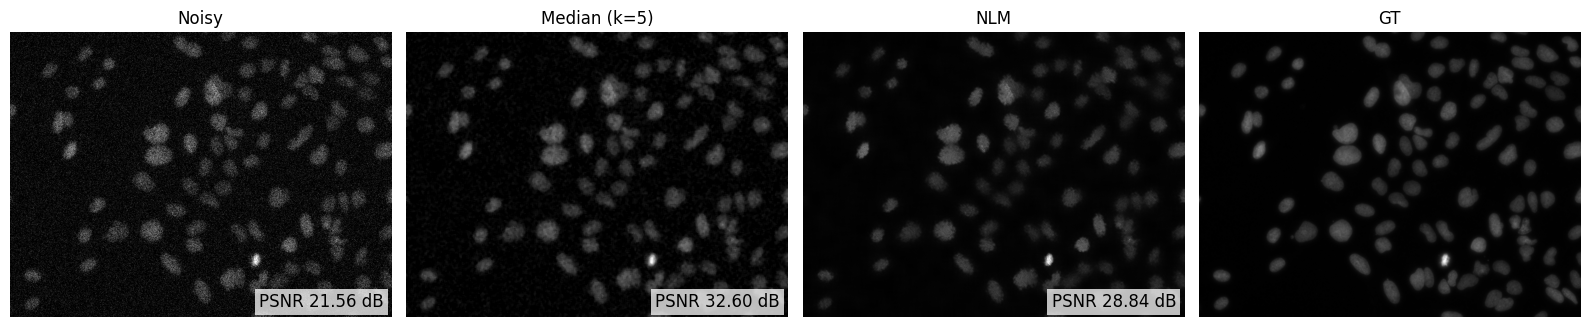

In [ ]:
from skimage.restoration import denoise_nl_means, estimate_sigma

# --- NLM Hyperparameters ---
# === You can change this value ===
PATCH_SIZE     = 5   # odd: [3, 5, 7]
PATCH_DISTANCE = 11   # search radius: [5, 7, 11] (bigger = slower)
H_FACTOR       = 1.5  # filtering strength multiplier (bigger = stronger denoise)
# ======
# ---------------------------

if noisy.ndim == 2:
    noisy_f = noisy.astype(np.float32) / 255.0
    sigma_est = float(np.mean(estimate_sigma(noisy_f, channel_axis=None)))
    h = H_FACTOR * sigma_est

    # non local means
    nlm_f = denoise_nl_means(
        noisy_f,
        h=h,
        patch_size=PATCH_SIZE,
        patch_distance=PATCH_DISTANCE,
        fast_mode=True,
        channel_axis=None
    )
    nlm_out = (np.clip(nlm_f, 0, 1) * 255).astype(np.uint8)

# ============================================================
# Visualization: Noisy / Median / NLM / GT
# ============================================================

def to_gray_u8(img):
    if img is None:
        return None
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return img

gt_vis     = to_gray_u8(gt)
noisy_vis  = to_gray_u8(noisy)
median_vis = to_gray_u8(median_out)
nlm_vis    = to_gray_u8(nlm_out)

# PSNR (vs GT)
psnr_noisy  = psnr(noisy_vis,  gt_vis)
psnr_median = psnr(median_vis, gt_vis)
psnr_nlm    = psnr(nlm_vis,    gt_vis)

# ---- Plot ----
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(noisy_vis, cmap="gray")
axes[0].set_title("Noisy"); axes[0].axis("off")
put_psnr(axes[0], psnr_noisy)

axes[1].imshow(median_vis, cmap="gray")
axes[1].set_title(f"Median (k={K_MED})"); axes[1].axis("off")
put_psnr(axes[1], psnr_median)

axes[2].imshow(nlm_vis, cmap="gray")
axes[2].set_title("NLM"); axes[2].axis("off")
put_psnr(axes[2], psnr_nlm)

axes[3].imshow(gt_vis, cmap="gray")
axes[3].set_title("GT"); axes[3].axis("off")

plt.tight_layout()
plt.show()


# Image Enhacnement

# Histogram Equalization

GT count: 300


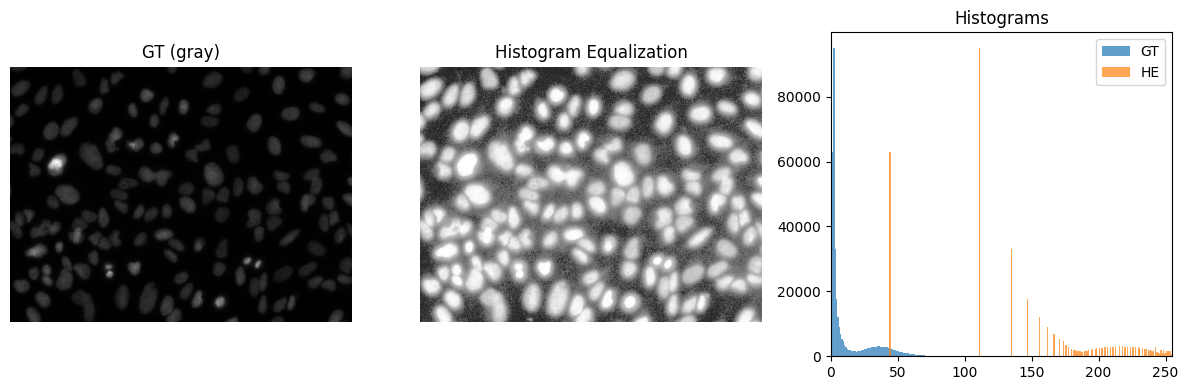

In [ ]:
import os, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

GT_DIR = "/content/NPL_Workshop_2026/data/GT"
# =====
idx = 100   # 0 ~ 299
# =====

exts = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
gt_files = sorted([p for p in glob.glob(os.path.join(GT_DIR, "*"))
                   if os.path.splitext(p)[1].lower() in exts])

print("GT count:", len(gt_files))

path = gt_files[min(max(idx, 0), len(gt_files)-1)]

img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
if img is None:
    raise RuntimeError(f"Failed to read: {path}")

if img.ndim == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

if img.dtype != np.uint8:
    img_u8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
else:
    img_u8 = img

# =======
he = cv2.equalizeHist(img_u8)
# ========

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("GT (gray)")
plt.imshow(img_u8, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Histogram Equalization")
plt.imshow(he, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Histograms")
plt.hist(img_u8.ravel(), bins=256, range=(0,255),
         label="GT", alpha=0.7)
plt.hist(he.ravel(), bins=256, range=(0,255),
         label="HE", alpha=0.7)
plt.xlim(0,255)
plt.legend()
plt.tight_layout()
plt.show()


# CLAHE

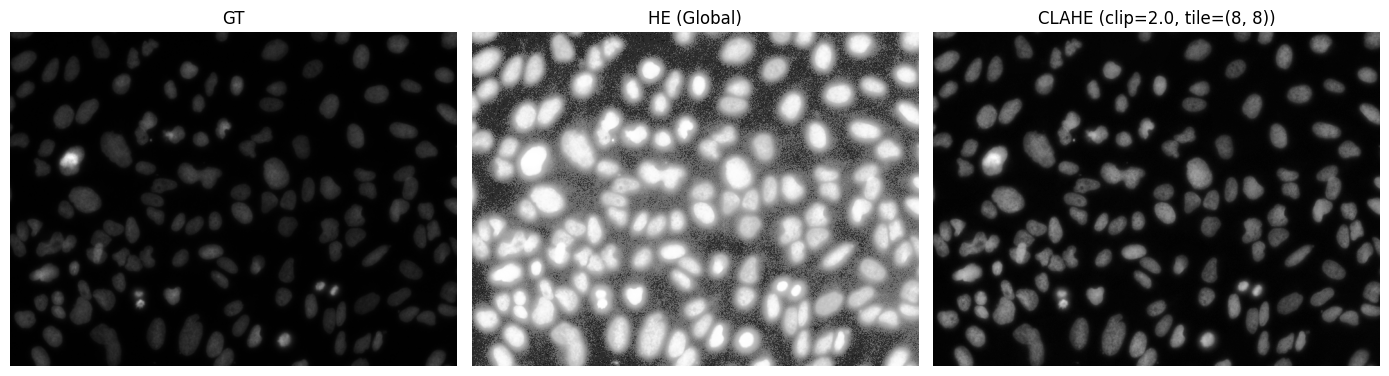

In [ ]:

import os, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

GT_DIR = "/content/NPL_Workshop_2026/data/GT"

# === You can change this value ===
idx = 100
CLIP_LIMIT = 2.0
TILE_GRID = (8, 8) # Tile Size
# ======

exts = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
gt_files = sorted([p for p in glob.glob(os.path.join(GT_DIR, "*"))
                   if os.path.splitext(p)[1].lower() in exts])

path = gt_files[min(max(idx, 0), len(gt_files)-1)]
img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
if img is None:
    raise RuntimeError(f"Failed to read: {path}")

if img.ndim == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

if img.dtype != np.uint8:
    img_u8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
else:
    img_u8 = img

# HE vs CLAHE
he = cv2.equalizeHist(img_u8)

clahe_obj = cv2.createCLAHE(clipLimit=CLIP_LIMIT, tileGridSize=TILE_GRID)
clahe = clahe_obj.apply(img_u8)

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.title("GT")
plt.imshow(img_u8, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("HE (Global)")
plt.imshow(he, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"CLAHE (clip={CLIP_LIMIT}, tile={TILE_GRID})")
plt.imshow(clahe, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


# Image Enhancement Using Deep Learning(Pix2Pix based)

In [ ]:

import os, glob, random
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from tqdm import tqdm

DATA_ROOT = "/content/NPL_Workshop_2026/data"

TRAIN_GT_DIR = os.path.join(DATA_ROOT,"GT")

TRAIN_IN_DIR = os.path.join(DATA_ROOT, "Input_noisy")


OUT_DIR = os.path.join(DATA_ROOT, "pix2pix_runs", "no_overfit_logic")
os.makedirs(OUT_DIR, exist_ok=True)

IMG_SIZE  = 256
# === You can change this value ===
BATCH     = 8
EPOCHS    = 100 # not too much, it needs much time
LR        = 1e-4
# ===
LAMBDA_L1 = 100.0

NUM_WORKERS = 2
SEED = 0
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)


DEVICE: cuda


[Dataset] Input files : 300
[Dataset] GT files    : 300
[Dataset] Matched pairs: 300
Batch X: torch.Size([8, 3, 256, 256]) Batch Y: torch.Size([8, 3, 256, 256])


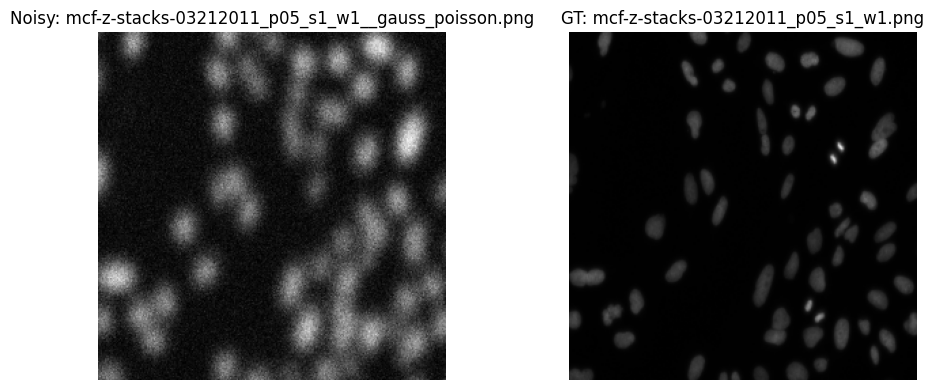

In [ ]:
EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

def list_images(folder):
    return sorted([p for p in glob.glob(os.path.join(folder, "*"))
                   if os.path.splitext(p)[1].lower() in EXTS])

def strip_suffix(name):
    stem, ext = os.path.splitext(name)
    for suf in ["__gauss_poisson", "__gauss", "__poisson"]:
        if stem.endswith(suf):
            stem = stem[:-len(suf)]
            break
    return stem + ext

class PairedDataset(Dataset):
    def __init__(self, in_dir, gt_dir, img_size=256, augment=True):
        self.img_size = img_size
        self.augment = augment

        in_files = list_images(in_dir)
        gt_map = {os.path.basename(p): p for p in list_images(gt_dir)}

        pairs = []
        for p_in in in_files:
            in_name = os.path.basename(p_in)
            gt_name = strip_suffix(in_name)
            if gt_name in gt_map:
                pairs.append((p_in, gt_map[gt_name], in_name, gt_name))

        assert len(pairs) > 0, "No matched pairs found."
        self.pairs = pairs
        print(f"[Dataset] Input files : {len(in_files)}")
        print(f"[Dataset] GT files    : {len(gt_map)}")
        print(f"[Dataset] Matched pairs: {len(self.pairs)}")

        self.to_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5,)*3, (0.5,)*3)  # [-1,1]
        ])

    def _read_rgb_u8(self, path):
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise RuntimeError(f"Failed to read: {path}")
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if img.dtype != np.uint8:
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, i):
        in_path, gt_path, in_name, gt_name = self.pairs[i]

        x = self._read_rgb_u8(in_path)
        y = self._read_rgb_u8(gt_path)

        x = cv2.resize(x, (self.img_size, self.img_size), interpolation=cv2.INTER_AREA)
        y = cv2.resize(y, (self.img_size, self.img_size), interpolation=cv2.INTER_AREA)

        if self.augment:
            if random.random() < 0.5:
                x = np.ascontiguousarray(np.flip(x, axis=1))
                y = np.ascontiguousarray(np.flip(y, axis=1))
            if random.random() < 0.5:
                x = np.ascontiguousarray(np.flip(x, axis=0))
                y = np.ascontiguousarray(np.flip(y, axis=0))

        x = self.to_tensor(Image.fromarray(x))
        y = self.to_tensor(Image.fromarray(y))
        return x, y, in_name, gt_name

train_ds = PairedDataset(TRAIN_IN_DIR, TRAIN_GT_DIR, img_size=IMG_SIZE, augment=True)
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

x, y, in_name, gt_name = next(iter(train_loader))
print("Batch X:", x.shape, "Batch Y:", y.shape)

def denorm_to_u8(t):
    t = (t * 0.5 + 0.5).clamp(0,1)
    return (t * 255.0).byte()

x, y, in_name, gt_name = next(iter(train_loader))
x0 = denorm_to_u8(x[0]).permute(1,2,0).numpy()
y0 = denorm_to_u8(y[0]).permute(1,2,0).numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(x0); plt.title(f"Noisy: {in_name[0]}"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(y0); plt.title(f"GT: {gt_name[0]}"); plt.axis("off")
plt.tight_layout()
plt.show()



In [ ]:
def conv_block(in_c, out_c, norm=True):
    layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)]
    if norm:
        layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

def deconv_block(in_c, out_c, dropout=False):
    layers = [
        nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
    ]
    if dropout:
        layers.append(nn.Dropout(0.5))
    return nn.Sequential(*layers)

class UNetGenerator(nn.Module):
    def __init__(self, in_ch=3, out_ch=3):
        super().__init__()
        self.e1 = conv_block(in_ch, 64,  norm=False)
        self.e2 = conv_block(64,   128, norm=True)
        self.e3 = conv_block(128,  256, norm=True)
        self.e4 = conv_block(256,  512, norm=True)
        self.e5 = conv_block(512,  512, norm=True)
        self.e6 = conv_block(512,  512, norm=True)
        self.e7 = conv_block(512,  512, norm=True)
        self.e8 = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1, bias=False),
                                nn.ReLU(inplace=True))

        self.d1 = deconv_block(512, 512, dropout=True)
        self.d2 = deconv_block(1024, 512, dropout=True)
        self.d3 = deconv_block(1024, 512, dropout=True)
        self.d4 = deconv_block(1024, 512, dropout=False)
        self.d5 = deconv_block(1024, 256, dropout=False)
        self.d6 = deconv_block(512,  128, dropout=False)
        self.d7 = deconv_block(256,  64,  dropout=False)
        self.d8 = nn.Sequential(nn.ConvTranspose2d(128, out_ch, 4, 2, 1),
                                nn.Tanh())

    def forward(self, x):
        e1 = self.e1(x); e2 = self.e2(e1); e3 = self.e3(e2); e4 = self.e4(e3)
        e5 = self.e5(e4); e6 = self.e6(e5); e7 = self.e7(e6); e8 = self.e8(e7)

        d1 = self.d1(e8)
        d2 = self.d2(torch.cat([d1, e7], dim=1))
        d3 = self.d3(torch.cat([d2, e6], dim=1))
        d4 = self.d4(torch.cat([d3, e5], dim=1))
        d5 = self.d5(torch.cat([d4, e4], dim=1))
        d6 = self.d6(torch.cat([d5, e3], dim=1))
        d7 = self.d7(torch.cat([d6, e2], dim=1))
        out = self.d8(torch.cat([d7, e1], dim=1))
        return out

class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=6):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 1)
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

G = UNetGenerator().to(DEVICE)
D = PatchDiscriminator().to(DEVICE)

print("G params(M):", sum(p.numel() for p in G.parameters())/1e6)
print("D params(M):", sum(p.numel() for p in D.parameters())/1e6)


G params(M): 54.413955
D params(M): 2.768705


In [ ]:
bce_logits = nn.BCEWithLogitsLoss()
l1 = nn.L1Loss()

opt_G = optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

def denorm_to_u8_batch(x):
    x = (x * 0.5 + 0.5).clamp(0,1)
    return (x * 255.0).byte()

@torch.no_grad()
def preview_one(save_path):
    G.eval()
    x, y, in_name, gt_name = next(iter(train_loader))
    x = x.to(DEVICE); y = y.to(DEVICE)
    yhat = G(x)

    x_u8 = denorm_to_u8_batch(x)[0].permute(1,2,0).cpu().numpy()
    p_u8 = denorm_to_u8_batch(yhat)[0].permute(1,2,0).cpu().numpy()
    y_u8 = denorm_to_u8_batch(y)[0].permute(1,2,0).cpu().numpy()

    canvas = np.concatenate([x_u8, p_u8, y_u8], axis=1)  # input | pred | gt
    cv2.imwrite(save_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
    G.train()


/tmp/ipython-input-1200844616.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))


In [ ]:
for epoch in range(1, EPOCHS+1):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:03d}/{EPOCHS}")

    for x, y, _, _ in pbar:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        # ---- Train D ----
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            y_fake = G(x).detach()
            pred_real = D(x, y)
            pred_fake = D(x, y_fake)

            lossD_real = bce_logits(pred_real, torch.ones_like(pred_real))
            lossD_fake = bce_logits(pred_fake, torch.zeros_like(pred_fake))
            lossD = 0.5 * (lossD_real + lossD_fake)

        opt_D.zero_grad(set_to_none=True)
        scaler.scale(lossD).backward()
        scaler.step(opt_D)

        # ---- Train G ----
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            y_fake = G(x)
            pred_fake_for_G = D(x, y_fake)

            lossG_gan = bce_logits(pred_fake_for_G, torch.ones_like(pred_fake_for_G))
            lossG_l1  = l1(y_fake, y) * LAMBDA_L1
            lossG = lossG_gan + lossG_l1

        opt_G.zero_grad(set_to_none=True)
        scaler.scale(lossG).backward()
        scaler.step(opt_G)
        scaler.update()

        pbar.set_postfix(lossD=float(lossD.item()),
                         lossG=float(lossG.item()),
                         gan=float(lossG_gan.item()),
                         l1=float(lossG_l1.item()))

    preview_path = os.path.join(OUT_DIR, f"preview_epoch{epoch:03d}.png")
    preview_one(preview_path)

last_path = os.path.join(OUT_DIR, "last_pix2pix.pth")
torch.save({
    "G": G.state_dict(),
    "D": D.state_dict(),
    "opt_G": opt_G.state_dict(),
    "opt_D": opt_D.state_dict(),
    "config": {
        "IMG_SIZE": IMG_SIZE, "BATCH": BATCH, "EPOCHS": EPOCHS,
        "LR": LR, "LAMBDA_L1": LAMBDA_L1
    }
}, last_path)

print("Saved:", last_path)


Epoch 001/100:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipython-input-3142743685.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
/tmp/ipython-input-3142743685.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
Epoch 100/100: 100%|██████████| 38/38 [00:05<00:00,  6.35it/s, gan=6.22, l1=5.14, lossD=0.0962, lossG=11.4]


Saved: /content/NPL_Workshop_2026/data/pix2pix_runs/no_overfit_logic/last_pix2pix.pth


In [ ]:
SAVE_PRED_DIR = os.path.join(OUT_DIR, "pred_input_noisy")
os.makedirs(SAVE_PRED_DIR, exist_ok=True)

ckpt = torch.load(last_path, map_location=DEVICE)
G.load_state_dict(ckpt["G"])
G.eval()

to_tensor = T.Compose([T.ToTensor(), T.Normalize((0.5,)*3, (0.5,)*3)])

def read_rgb_u8(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise RuntimeError(f"Failed to read: {path}")
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return img

@torch.no_grad()
def enhance_one(path):
    bgr = read_rgb_u8(path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    x = to_tensor(Image.fromarray(rgb)).unsqueeze(0).to(DEVICE)

    yhat = G(x)
    out = denorm_to_u8_batch(yhat)[0].permute(1,2,0).cpu().numpy()
    out_bgr = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
    return out_bgr

in_files = list_images(TRAIN_IN_DIR)
print("Enhance count:", len(in_files))

for p in tqdm(in_files):
    out = enhance_one(p)
    cv2.imwrite(os.path.join(SAVE_PRED_DIR, os.path.basename(p)), out)

print("Saved enhanced PNGs to:", SAVE_PRED_DIR)


Enhance count: 300


100%|██████████| 300/300 [00:06<00:00, 45.05it/s]

Saved enhanced PNGs to: /content/NPL_Workshop_2026/data/pix2pix_runs/no_overfit_logic/pred_input_noisy


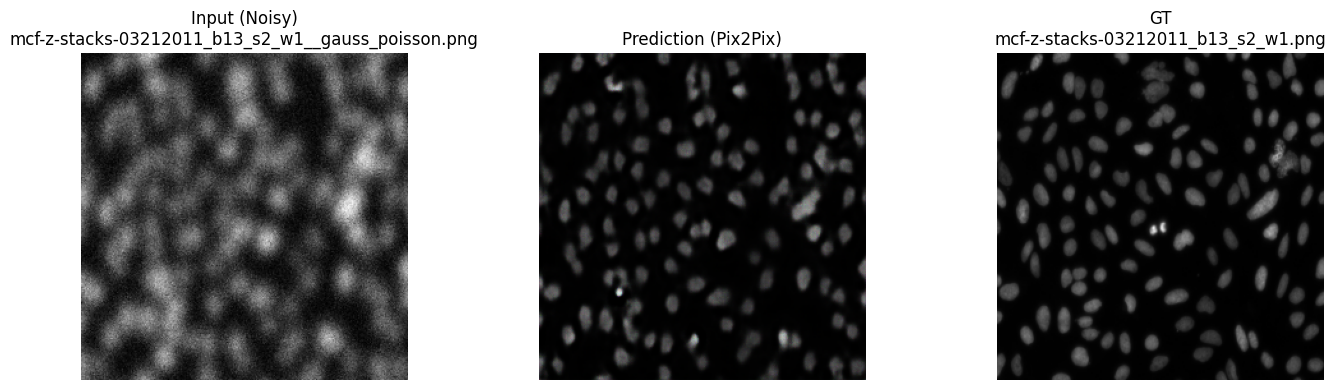

In [ ]:
idx = 30
x, y, in_name, gt_name = train_ds[idx]

G.eval()
with torch.no_grad():
    x_in = x.unsqueeze(0).to(DEVICE)
    yhat = G(x_in)[0].cpu()
G.train()

x_u8 = denorm_to_u8(x).permute(1,2,0).numpy()
y_u8 = denorm_to_u8(y).permute(1,2,0).numpy()
p_u8 = denorm_to_u8(yhat).permute(1,2,0).numpy()

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.imshow(x_u8)
plt.title(f"Input (Noisy)\n{in_name}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(p_u8)
plt.title("Prediction (Pix2Pix)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(y_u8)
plt.title(f"GT\n{gt_name}")
plt.axis("off")

plt.tight_layout()
plt.show()